In [107]:
#Import Libraries
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import statsmodels.tsa
import statsmodels.tsa.seasonal
import pmdarima as pm
from sklearn.metrics import mean_squared_error
from math import sqrt
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [94]:
#Read data
Kingston = pd.read_csv(r"C:\Users\Tom-T\Google Drive\Queen's MMA\Predictive Modelling - MMA 867\Assignment 2 (Team)\kingston_clean.csv")

#Some data cleansing
Kingston = Kingston.assign(Date=pd.to_datetime(Kingston[['Year', 'Month']].assign(day=1)))
Kingston = Kingston.replace(-99.99,np.nan)
Kingston = Kingston.assign(Temp=Kingston['Temp_Diff'])
Data = Kingston[['Date','Temp']]
Data = Data.sort_values(by='Date', ascending=True)
Data.reset_index(drop=True, inplace=True)
Data.set_index('Date', inplace=True)

Data.head()

,Temp
Date,
1872-01-01,NaN
1872-02-01,NaN
1872-03-01,NaN
1872-04-01,NaN
1872-05-01,NaN


In [95]:
#Use only data from 1940 onwards
Data = Data.loc['1940':]
Data = Data.asfreq('M', method='bfill')
Data.head()

,Temp
Date,
1940-01-31,NaN
1940-02-29,NaN
1940-03-31,NaN
1940-04-30,NaN
1940-05-31,NaN


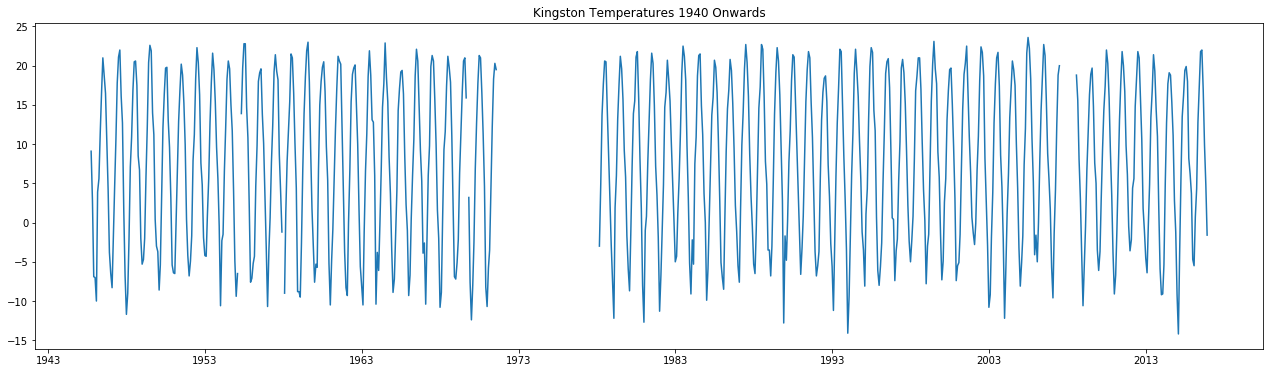

In [96]:
#Checking the data - how many records are missing? Missing data is incompatible with some models (ets, tbats) ... from FPP
plt.figure(figsize=(22,6))
plt.plot(Data.index, Data['Temp'])
plt.title('Kingston Temperatures 1940 Onwards')
plt.show()

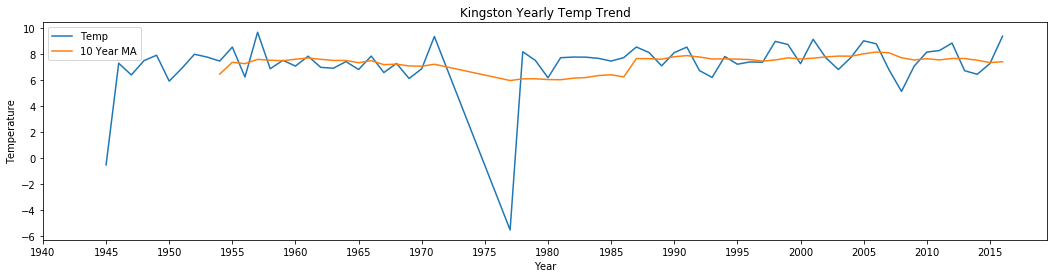

In [119]:
#Check for trends
ten_yr_MA = pd.pivot_table(Data, values='Temp', index=Data.index.year, aggfunc='mean')
ten_yr_MA['10 Year MA'] = ten_yr_MA['Temp'].rolling(10).mean()
ten_yr_MA[['Temp','10 Year MA']].plot(figsize=(18,4))
plt.title('Kingston Yearly Temp Trend')
plt.xlabel('Year')
plt.ylabel('Temperature')
plt.xticks([x for x in range(1940,2020,5)])
plt.show()

#from this we see there isn't really a trend in the moving average (10 year). Thus for our model we can set trend = none

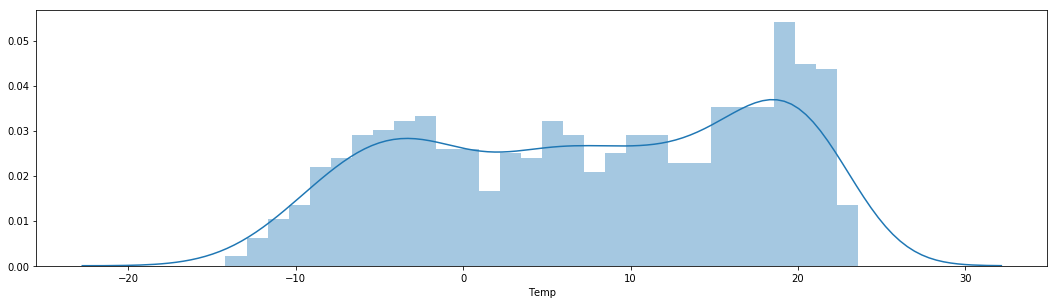

In [103]:
#Let's observe the distribution of observations
plt.figure(figsize=(28,16))
ax4 = plt.subplot2grid((3, 3), (2, 0), colspan=2)
sns.distplot(Data['Temp'], bins=int(sqrt(len(Data['Temp']))), ax=ax4)
plt.show()

In [ ]:
#Split Dataset. Train, Validation, and Test sets
train = Data[:-60].copy()
val = Data[-60:-12].copy()
test = Data[-12:].copy()

In [214]:
#As there was significant chunks of missing data with no means to impute values, it was impossible to create
#ACF and PACF charts to help set ARIMA parameters. Additionally, auto-arima was unusable as pmdarima does not 
#support missing values in its auto arima function. Thus a baseline model was selected from this excellent resource from
#Duke University, by Professor Robert Nau: https://people.duke.edu/~rnau/seasarim.htm

#For CV, selected last 5 years as testing set, with the remainder from 1940 as the training set

#Nonseasonal model
Kingston_arima = pm.ARIMA(order=(0,1,1), maxiter=100,suppress_warnings=True)
Kingston_arima.fit(Data)
# #Resulting AIC = 4646.752

#Seasonal model
Kingston_sarima = pm.ARIMA(order=(0,1,1), seasonal_order=(0,1,1,12), maxiter=100,suppress_warnings=True)
Kingston_sarima.fit(Data)
#Resulting AIC = 3367.319

Kingston_sarima.fit(Data).summary()
Kingston_arima.fit(Data).summary()

#Evidently, there is a seasonality and the seasonal ARIMA model fits much better
#Using some additional guidelines for setting ARIMA parameters, from Nau's site:

#As it was observed in the initial S Arima model, the sum of the nonseasonal MA feature coefficients was nearly a unit root (1)
#Thus I reduced both d and q by 1

#Seasonal model
Kingston_sarima = pm.ARIMA(order=(0,0,0), seasonal_order=(0,1,1,12), maxiter=100,suppress_warnings=True)
Kingston_sarima.fit(Data)
# #Resulting AIC = 3342.042

#The result is a better fit!

#Lastly, I tried adding a variable number of nonseasonal and seasonal AR terms. I tested a range of 1-7 for each, and found
#the resuling model to have the best AIC score
Kingston_sarima = pm.ARIMA(order=(7,0,0), seasonal_order=(0,1,1,12), maxiter=100,suppress_warnings=True)
Kingston_sarima.fit(Data)
#Resulting AIC = 3326.652

Kingston_sarima.fit(Data).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                                    y   No. Observations:                  923
Model:             SARIMAX(7, 0, 0)x(0, 1, [1], 12)   Log Likelihood               -1653.326
Date:                              Sat, 16 May 2020   AIC                           3326.652
Time:                                      16:54:15   BIC                           3374.797
Sample:                                           0   HQIC                          3345.033
                                              - 923                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0069      0.004      1.725      0.084      -0.001       0.015
ar.L1          0.1295      0.028      4.560      0.000       0.074       0.185
ar.L2          0.0711      0.038      1.851      0.064      -0.004       0.146
ar.L3          0.0491      0.043      1.147      0.251      -0.035       0.133
ar.L4          0.0311      0.044      0.701      0.483      -0.056       0.118
ar.L5         -0.0351      0.046     -0.760      0.447      -0.126       0.055
ar.L6          0.0562      0.050      1.122      0.262      -0.042       0.154
ar.L7          0.0438      0.046      0.950      0.342      -0.047       0.134
ma.S.L12      -0.9718      0.019    -52.421      0.000      -1.008      -0.936
sigma2         3.5526      0.151     23.587      0.000       3.257       3.848
===================================================================================
Ljung-Box (Q):                       32.92   Jarque-Bera (JB):               280.80
Prob(Q):                              0.78   Prob(JB):                         0.00
Heteroskedasticity (H):               1.27   Skew:                            -0.20
Prob(H) (two-sided):                  0.04   Kurtosis:                         5.69
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

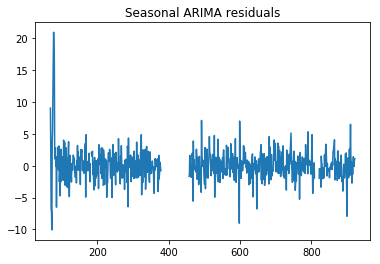

In [215]:
#Check residual stability (Stationarity check)
residuals = Kingston_sarima.resid()
plt.plot(residuals)
plt.title("Seasonal ARIMA residuals")
plt.show()

#Resulting residuals from model look relative stable

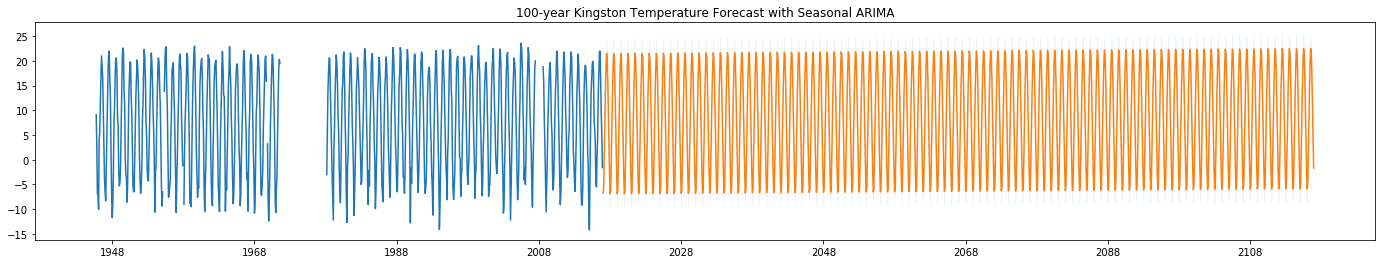

In [216]:
#Forecast out the next 1200 months (100 years)
n_periods = 1200
fitted, confint = Kingston_sarima.predict(n_periods, return_conf_int=True, alpha=.1)
index_of_fc = pd.date_range(Data.index[-1], periods = n_periods + 1, freq='MS')[1:]

prediction = pd.Series(fitted, index=index_of_fc)
lower_bound = pd.Series(confint[:, 0], index=index_of_fc)
upper_bound = pd.Series(confint[:, 1], index=index_of_fc)

plt.figure(figsize=(24,4))
plt.plot(Data)
plt.plot(prediction)
plt.fill_between(lower_bound.index, 
                 lower_bound, 
                 upper_bound, 
                 alpha=.10)


plt.title("100-year Kingston Temperature Forecast with Seasonal ARIMA")
plt.show()

In [217]:
prediction_output = prediction.to_frame(name='Point Prediction')
lower_bound_output = lower_bound.to_frame(name='Lower 90% CI')
upper_bound_output = upper_bound.to_frame(name='Upper 90% CI')

In [219]:
Prediction_Final1 = prediction_output.merge(lower_bound_output, how='inner',left_index=True, right_index=True)
Prediction_Final = Prediction_Final1.merge(upper_bound_output, how='inner',left_index=True, right_index=True)

In [221]:
Prediction_Final.head()
Prediction_Final.to_csv(r"C:\Users\Tom-T\Google Drive\Queen's MMA\Predictive Modelling - MMA 867\Assignment 2 (Team)\Kingston Predictions.csv")